In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# from main import main, main_search
# from utils import *
# from grid_search import *
from monthly_events_by_year import monthly_events_by_year
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
import numpy as np
import jax.numpy as jnp

In [2]:
@staticmethod
def add_event_binaries(df, monthly_events_by_year):
    """
    Menambahkan kolom binary untuk setiap event pada monthly_events_by_year.
    Kolom: is_eventname (True jika di bulan & tahun event, False jika tidak)
    """
    import re

    # Buat set semua nama event unik
    all_events = set()
    for tahun in monthly_events_by_year:
        for bulan in monthly_events_by_year[tahun]:
            for event in monthly_events_by_year[tahun][bulan]:
                all_events.add(event)

    # Normalisasi nama event untuk nama kolom (huruf kecil, spasi jadi _)
    def norm_colname(event):
        return "is_" + re.sub(r'\W+', '_', event.lower()).strip('_')

    # Siapkan dict mapping (tahun, bulan) ke event
    event_map = {}
    for tahun in monthly_events_by_year:
        for bulan in monthly_events_by_year[tahun]:
            for event in monthly_events_by_year[tahun][bulan]:
                event_map.setdefault((int(tahun), int(bulan)), []).append(event)

    # Untuk setiap event, buat kolom binary
    for event in all_events:
        colname = norm_colname(event)
        df[colname] = 0  # default False

    # Isi True jika di bulan & tahun event
    for idx, row in df.iterrows():
        th = pd.to_datetime(row['monthyear']).year
        bl = pd.to_datetime(row['monthyear']).month
        events = event_map.get((th, bl), [])
        for event in events:
            colname = norm_colname(event)
            df.at[idx, colname] = 1

    return df

In [3]:
df = pd.read_csv('../dataset/data_clean.csv')
df = add_event_binaries(df, monthly_events_by_year)
df["event_count"] = df[[c for c in df.columns if c.startswith("is_")]].sum(axis=1)
df = df.drop([c for c in df.columns if c.startswith("is_")], axis=1)
df

,monthyear,business_level,category,brand,Sales Amount,Spend on meta Amount,Spend on tv Amount,Spend on ucontent Amount,Spend on youtube Amount,event_count
0,2018-01-01,Business Unit 1,Category 1,Brand 1,1.262415e+11,3.092581e+09,1.954508e+09,0.0,0.000000e+00,1
1,2018-02-01,Business Unit 1,Category 1,Brand 1,1.160802e+11,1.991768e+09,2.028384e+09,0.0,0.000000e+00,2
2,2018-03-01,Business Unit 1,Category 1,Brand 1,1.227369e+11,5.927829e+09,1.601623e+09,0.0,9.424770e+08,3
3,2018-04-01,Business Unit 1,Category 1,Brand 1,1.265799e+11,2.638936e+09,1.638252e+09,0.0,0.000000e+00,1
4,2018-05-01,Business Unit 1,Category 1,Brand 1,1.327130e+11,3.644244e+09,8.573104e+09,0.0,0.000000e+00,4
...,...,...,...,...,...,...,...,...,...,...
3610,2024-09-01,Business Unit 5,Category 20,Brand 74,1.255168e+11,4.400140e+09,0.000000e+00,0.0,0.000000e+00,2
3611,2025-02-01,Business Unit 5,Category 20,Brand 74,8.408039e+10,1.002167e+09,0.000000e+00,0.0,0.000000e+00,1
3612,2025-03-01,Business Unit 5,Category 20,Brand 74,8.668484e+10,5.251042e+09,0.000000e+00,0.0,1.413716e+09,3
3613,2025-04-01,Business Unit 5,Category 20,Brand 74,1.328104e+11,4.202002e+09,0.000000e+00,0.0,1.099556e+09,2


In [4]:
def model_mmm(df, category, value):
    import pickle
    df_agg = df.groupby(['monthyear', category], as_index=False).sum(numeric_only=True)
    df = df_agg[df_agg[category] == value]
    df.drop(columns=['monthyear', category], inplace=True)
    
    # ----------------------
    # 2. Scaling
    # ----------------------
    channels = [
                'Spend on meta Amount', 
                'Spend on tv Amount', 
                'Spend on ucontent Amount', 
                'Spend on youtube Amount'
            ]
    media_data = df[channels].values
    target = df["Sales Amount"].values
    extra_features = df[["event_count"]].values
    costs = media_data.copy() # misalnya pakai spend langsung sebagai prior

    # Split and scale data.
    split_point = media_data.shape[0] - 12
    # Media data
    media_data_train = media_data[:split_point, ...]
    media_data_test = media_data[split_point:, ...]
    # Extra features
    extra_features_train = extra_features[:split_point, ...]
    extra_features_test = extra_features[split_point:, ...]
    # Target
    target_train = target[:split_point]

    # Scalers
    media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
    extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
    target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
    cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)


    media_data_train = media_scaler.fit_transform(media_data)
    extra_features_train = extra_features_scaler.fit_transform(extra_features)
    target_train = target_scaler.fit_transform(target)
    costs_train = cost_scaler.fit_transform(costs)


    costs_prior = costs_train.sum(axis=0)  
    costs_prior = jnp.array(costs_prior)

    mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

    number_warmup = 1000
    number_samples = 1000
    SEED = 42

    mmm.fit(
        media=media_data_train,
        media_prior=costs_prior,    # <--- pakai costs_prior, bukan costs_train
        target=target_train,
        extra_features=extra_features_train,
        number_warmup=number_warmup,
        number_samples=number_samples,
        seed=SEED
    )
    # We can use the utilities for saving models to disk.
    file_path = f"mmm_{category}_{value}.pkl"
    utils.save_model(media_mix_model=mmm, file_path=file_path)

    # Simpan semua scaler ke file terpisah (atau satu file dict)
    scaler_dict = {
        "media_scaler": media_scaler,
        "extra_features_scaler": extra_features_scaler,
        "target_scaler": target_scaler,
        "cost_scaler": cost_scaler
    }
    with open(f"scaler_{category}_{value}.pkl", "wb") as f:
        pickle.dump(scaler_dict, f)
    


In [5]:
# for values in df['business_level'].unique():
#     model_mmm(df, 'business_level', values)

In [ ]:
category = 'business_level'
value = 'Business Unit 1'
df_agg = df.groupby(['monthyear', category], as_index=False).sum(numeric_only=True)
df = df_agg[df_agg[category] == value]
df.drop(columns=['monthyear', category], inplace=True)

# ----------------------
# 2. Scaling
# ----------------------
channels = [
            'Spend on meta Amount', 
            'Spend on tv Amount', 
            'Spend on ucontent Amount', 
            'Spend on youtube Amount'
        ]
media_data = df[channels].values
target = df["Sales Amount"].values
extra_features = df[["event_count"]].values
costs = media_data.copy() # misalnya pakai spend langsung sebagai prior

# Split and scale data.
split_point = media_data.shape[0] - 12
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

# Scalers
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)


media_data_train = media_scaler.fit_transform(media_data)
extra_features_train = extra_features_scaler.fit_transform(extra_features)
target_train = target_scaler.fit_transform(target)
costs_train = cost_scaler.fit_transform(costs)


costs_prior = costs_train.sum(axis=0)  
costs_prior = jnp.array(costs_prior)

mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

number_warmup = 1000
number_samples = 1000
SEED = 42

channel_names = ['meta', 'tv', 'ucontent', 'youtube']
mmm.fit(
    media=media_data_train,
    media_prior=costs_prior,    # <--- pakai costs_prior, bukan costs_train
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seasonality_frequency=12,  # untuk data bulanan
    seed=SEED,
    channel_names=channel_names
)

sample: 100%|██████████| 2000/2000 [00:09<00:00, 200.99it/s, 63 steps of size 4.60e-02. acc. prob=0.82] 


In [14]:
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.51      0.25      0.51      0.13      0.92    736.03      1.00
ad_effect_retention_rate[1]      0.52      0.29      0.52      0.11      1.00    701.05      1.00
ad_effect_retention_rate[2]      0.52      0.30      0.52      0.11      1.00    779.80      1.00
ad_effect_retention_rate[3]      0.64      0.23      0.69      0.28      0.97    581.87      1.00
     coef_extra_features[0]     -0.01      0.01     -0.01     -0.03      0.01    594.02      1.01
              coef_media[0]      0.10      0.04      0.10      0.03      0.16    403.71      1.00
              coef_media[1]      0.03      0.02      0.02      0.00      0.06    323.31      1.00
              coef_media[2]      0.02      0.01      0.02      0.00      0.04    526.96      1.00
              coef_media[3]      0.05      0.02      0.05      0.02      0.09    494.19      1.01
              coef_

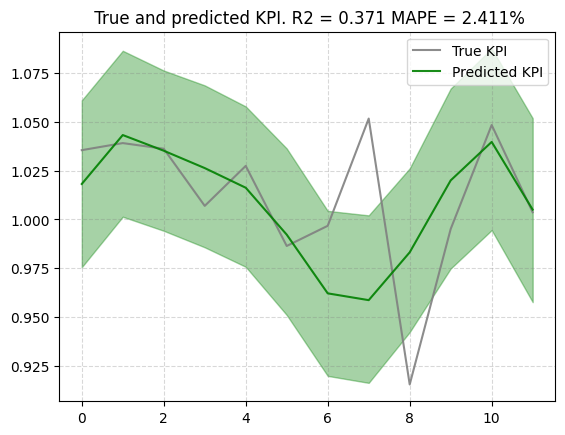

In [ ]:
# Once saved one can load the models.
# Load model
import pickle
mmm = utils.load_model(file_path="mmm_business_level_Business Unit 1.pkl")

# Load scaler
with open("scaler_business_level_Business Unit 1.pkl", "rb") as f:
    scalers = pickle.load(f)
media_scaler = scalers["media_scaler"]
target_scaler = scalers["target_scaler"]
cost_scaler = scalers["cost_scaler"]

media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

# Here is another example where we can pass the target scaler if you want the plot to be in the "not scaled scale"
plot.plot_model_fit(mmm, target_scaler=target_scaler)
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

In [8]:

media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

# Misal media_contribution.shape = (2000, 4)
# channel names sesuai urutan di data
channels = ["tv", "youtube", "ucontent", "meta"]

# Buat list untuk menyimpan data summary tiap channel
summary_list = []

for i, ch in enumerate(channels):
    contrib = media_contribution[:, i]
    roi = roi_hat[:, i]
    
    summary_list.append({
        "channel": ch,
        "mean_contribution": contrib.mean(),
        "median_contribution": np.median(contrib),
        "std_contribution": contrib.std(),
        "5%_contribution": np.percentile(contrib, 5),
        "95%_contribution": np.percentile(contrib, 95),
        "mean_roi": roi.mean(),
        "median_roi": np.median(roi),
        "std_roi": roi.std(),
        "5%_roi": np.percentile(roi, 5),
        "95%_roi": np.percentile(roi, 95)
    })

# Buat dataframe
df_summary = pd.DataFrame(summary_list)

df_summary


,channel,mean_contribution,median_contribution,std_contribution,5%_contribution,95%_contribution,mean_roi,median_roi,std_roi,5%_roi,95%_roi
0,tv,0.09935379,0.097072,0.039580867,0.038346,0.166607,4.917798,4.800755,1.9598624,1.906410,8.203391
1,youtube,0.026109766,0.020883,0.021336133,0.001803,0.069697,1.0983001,0.877150,0.8975852,0.076076,2.928406
2,ucontent,0.018680837,0.018419,0.008969524,0.004806,0.034042,46.414345,45.748711,22.285204,12.002966,84.321928
3,meta,0.053392325,0.051888,0.023297064,0.018040,0.093761,9.422723,9.152646,4.111941,3.196253,16.560858


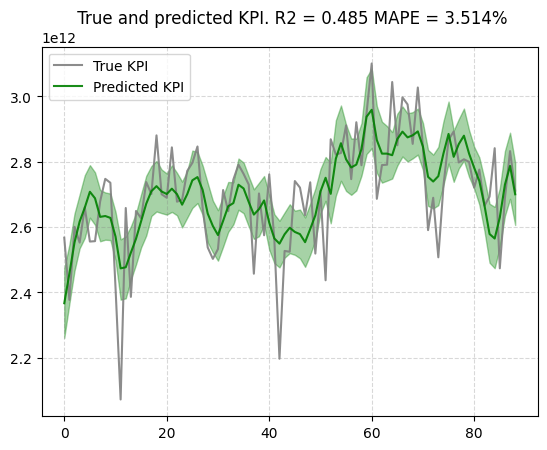

In [9]:
# Here is another example where we can pass the target scaler if you want the plot to be in the "not scaled scale"
plot.plot_model_fit(mmm, target_scaler=target_scaler)

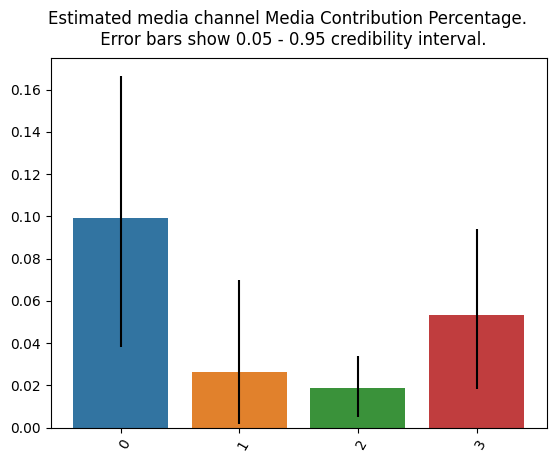

In [10]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")

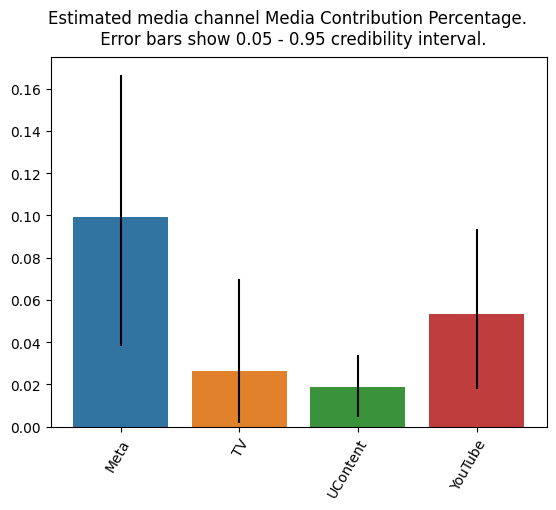

In [13]:
channel_names = ["Meta", "TV", "UContent", "YouTube"]
fig = plot.plot_bars_media_metrics(
    metric=media_contribution,
    metric_name="Media Contribution Percentage",
    channel_names=channel_names
)
fig = plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")
fig = plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")
ax = fig.axes[0]
ax.set_xticklabels(["Meta", "TV", "UContent", "YouTube"])
fig

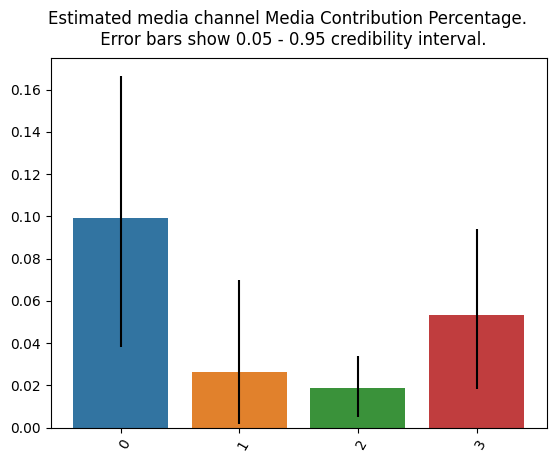

In [9]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")

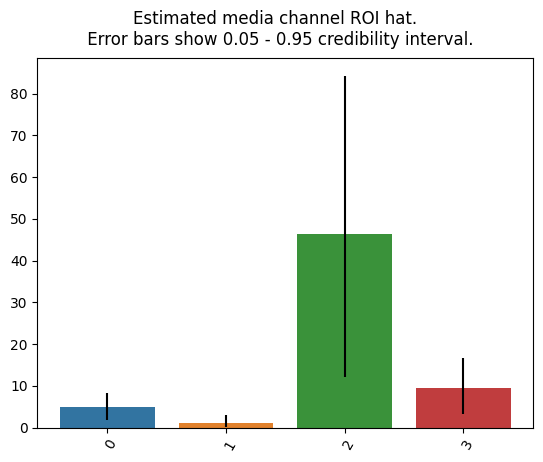

In [11]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")

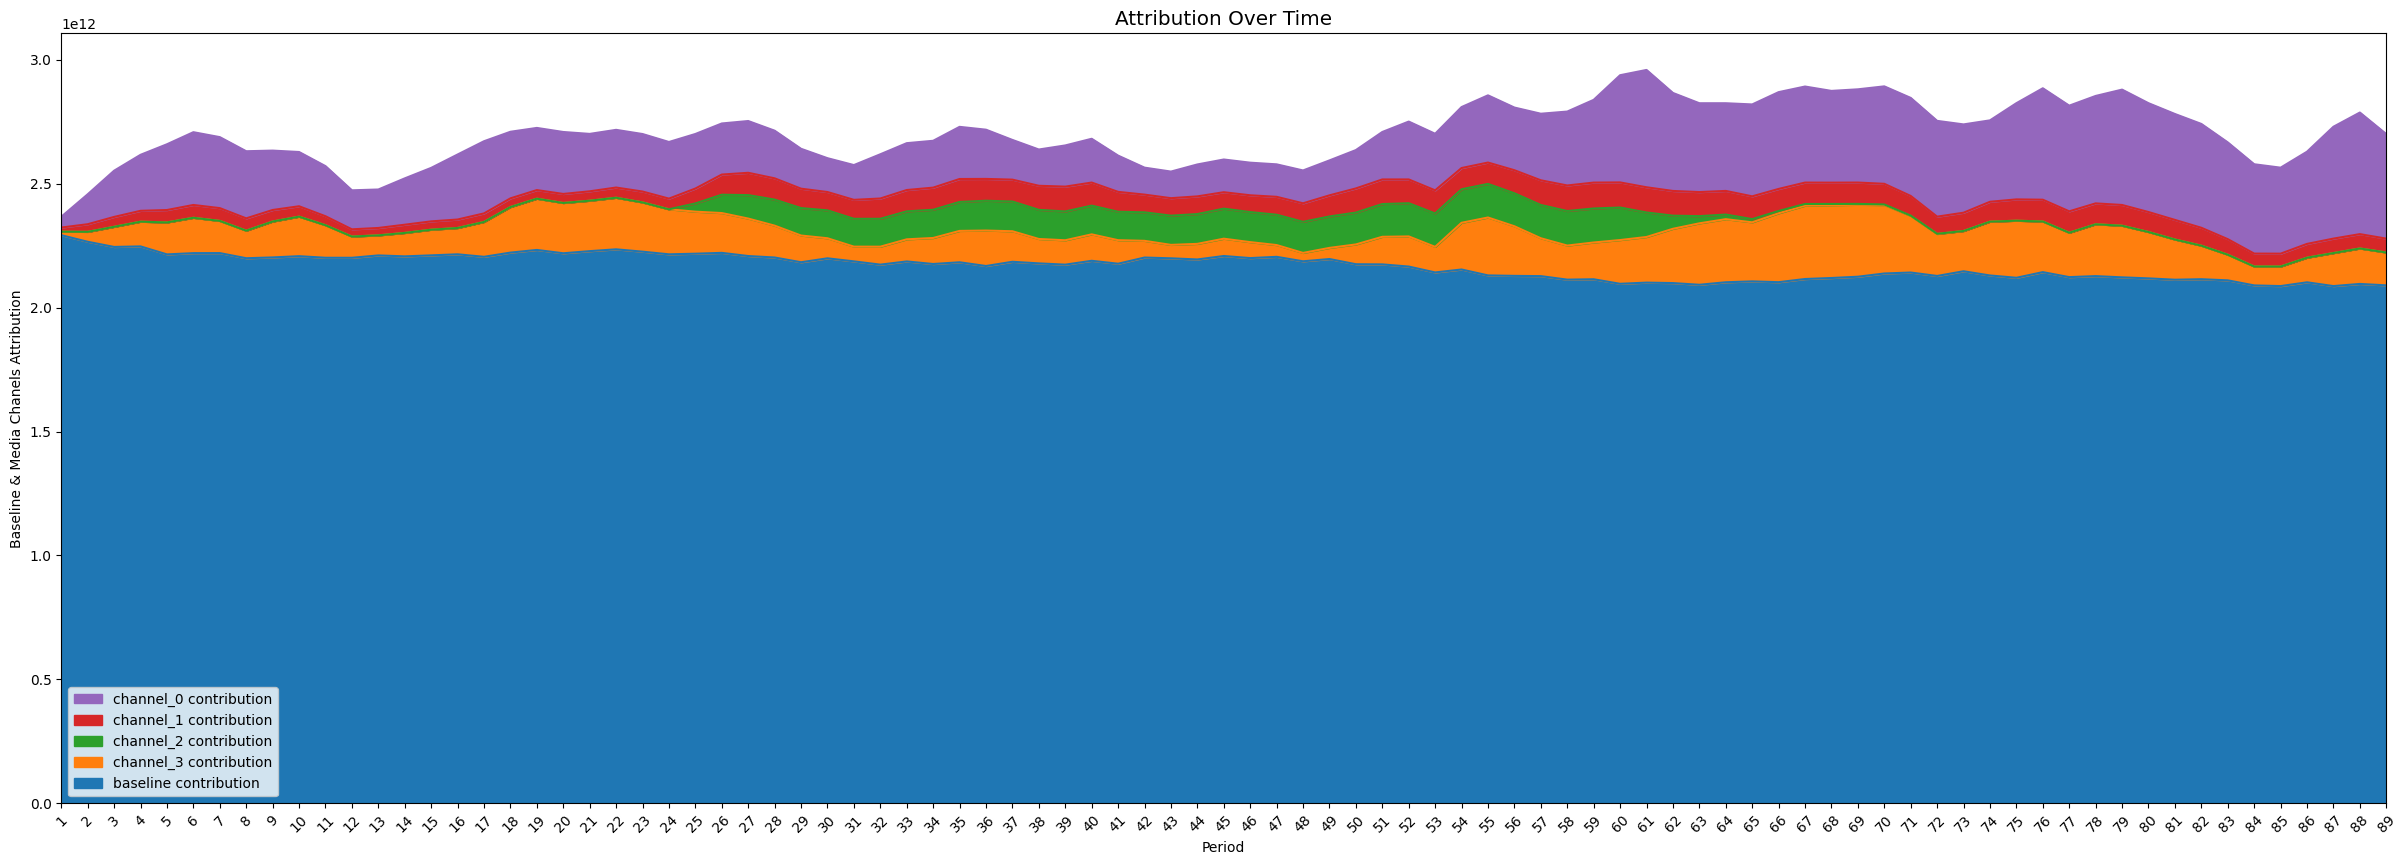

In [12]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

In [13]:
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)
new_predictions.shape

(2000, 12)

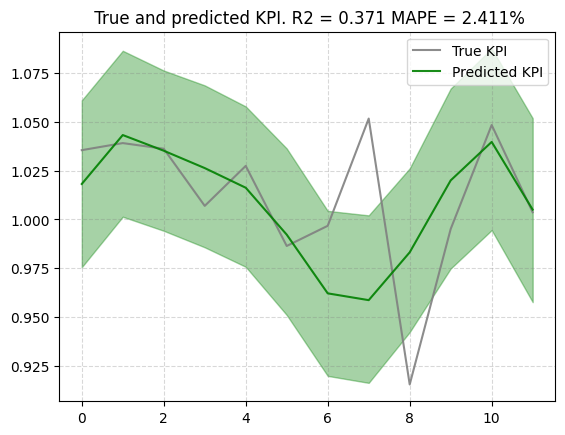

In [14]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

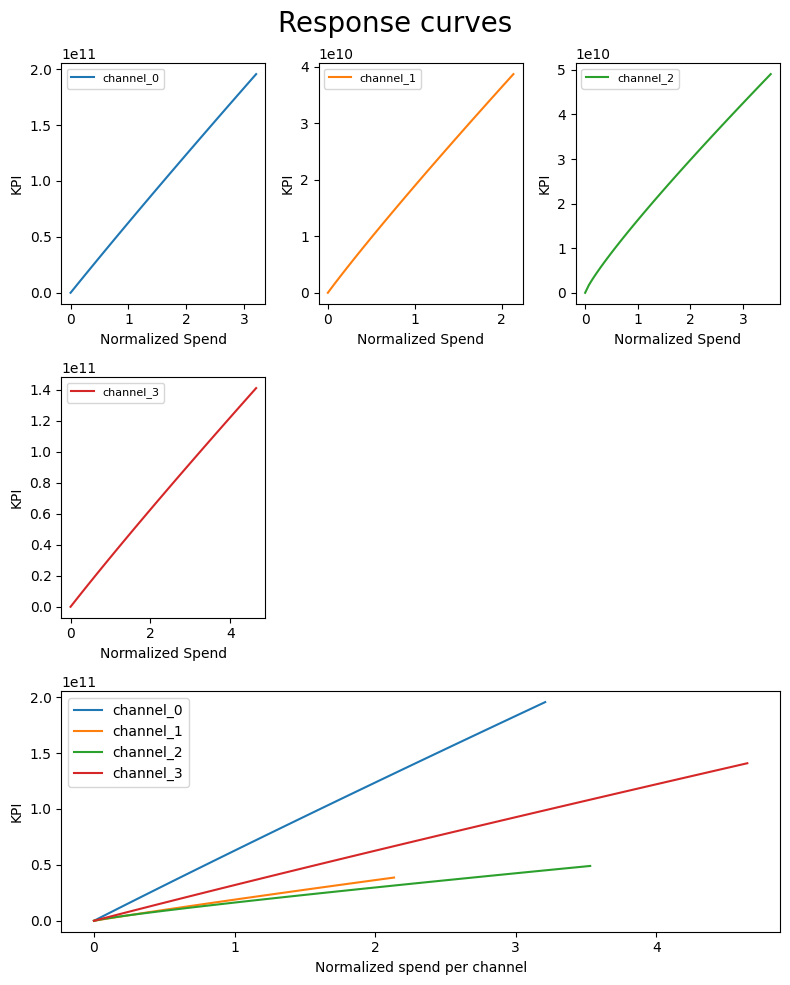

In [15]:
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

In [16]:
prices = jnp.ones(mmm.n_media_channels)

In [17]:
pd.DataFrame(media_data)

,0,1,2,3
0,2.627459e+10,4.541591e+10,0.0,4.712385e+09
1,3.957637e+10,4.259868e+10,0.0,8.482293e+09
2,4.851137e+10,4.219234e+10,0.0,1.663880e+10
3,4.916146e+10,4.084044e+10,0.0,7.304197e+09
4,6.921435e+10,5.682791e+10,0.0,2.368323e+10
...,...,...,...,...
84,7.594298e+10,5.326534e+10,0.0,1.284208e+10
85,8.766542e+10,5.461351e+10,0.0,1.353104e+10
86,1.324321e+11,5.174074e+10,0.0,2.115393e+10
87,8.091244e+10,4.647322e+10,0.0,1.074013e+10


In [18]:
n_time_periods = 12
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [20]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -32633010282342.414
            Iterations: 79
            Function evaluations: 769
            Gradient evaluations: 76


In [23]:
solution

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: -32633010282342.414
           x: [ 7.698e+11  6.165e+11  1.566e+10  2.204e+11]
         nit: 79
         jac: [-3.972e+00 -8.709e-01 -3.821e+01 -7.455e+00]
        nfev: 769
        njev: 76
 multipliers: [-3.972e+00]

In [24]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([7.6978690e+11, 6.1652573e+11, 1.5658386e+10, 2.2044580e+11],      dtype=float32)

In [25]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([6.5500624e+11, 7.7065703e+11, 1.3048652e+10, 1.8370480e+11],      dtype=float32)

In [26]:
# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(Array(1.6224168e+12, dtype=float32), Array(1.6224168e+12, dtype=float32))

In [27]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(Array(1.6224168e+12, dtype=float32), Array(1.6224168e+12, dtype=float32))

In [28]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(Array(1.6224168e+12, dtype=float32), Array(1.6224168e+12, dtype=float32))

In [29]:
kpi_without_optim

Array(-3.19296849e+13, dtype=float64)

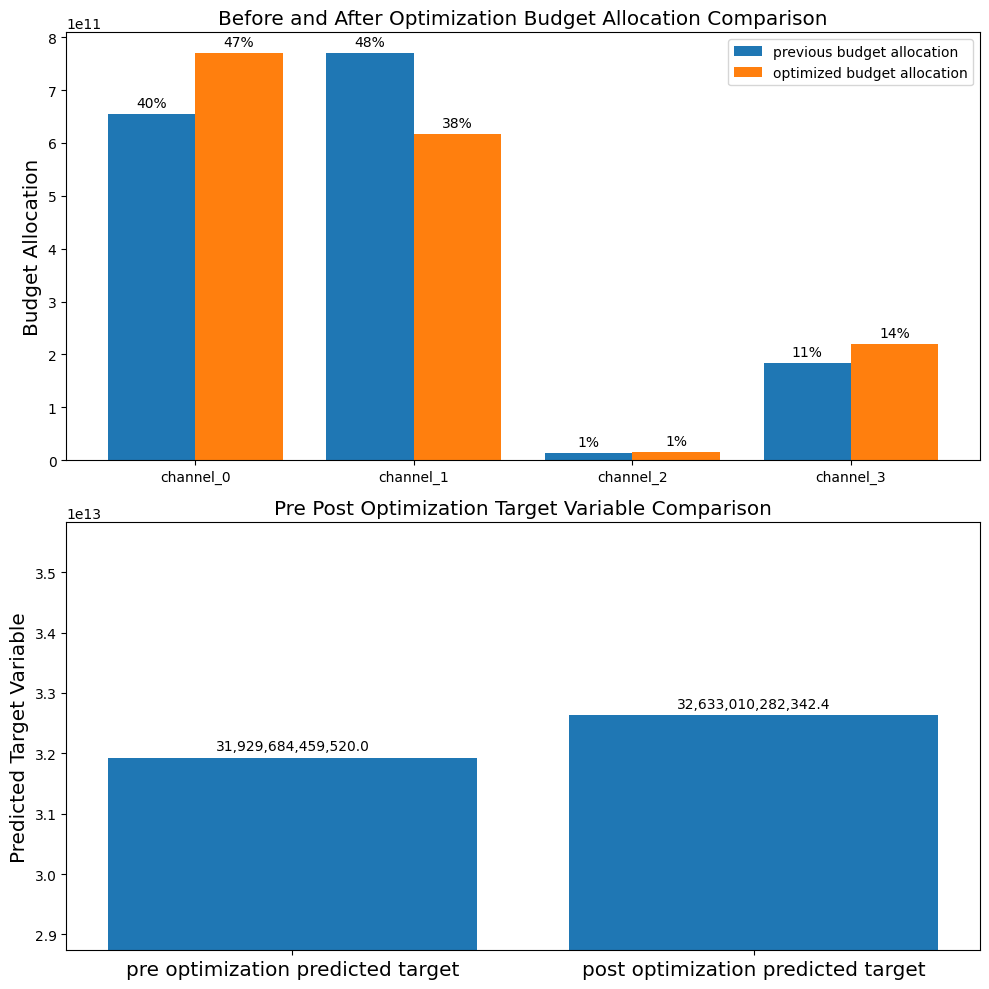

In [30]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10))

In [31]:
import sys
print(sys.executable)

c:\Users\Finshot\anaconda3\envs\mmm-py311\python.exe
